In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


In [7]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left")
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:05<00:00, 11.92it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-28 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


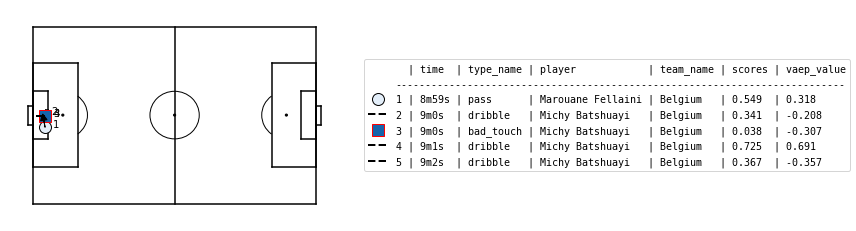

2018-06-28 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


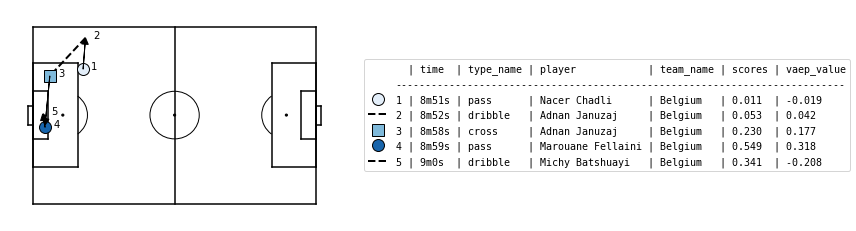

2018-06-23 Belgium 5-2 Tunisia 80' cross Kevin De Bruyne


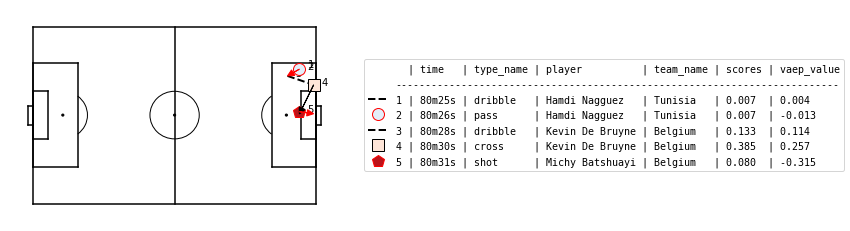

2018-07-02 Belgium 3-2 Japan 77' cross Nacer Chadli


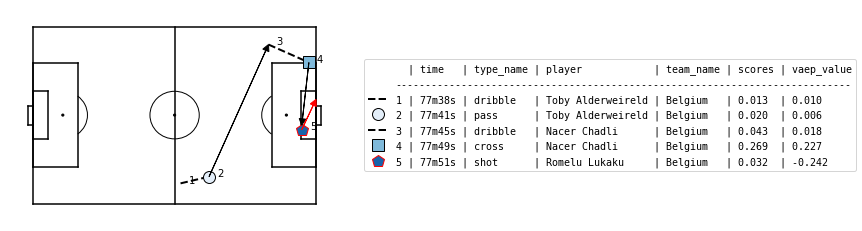

2018-07-02 Belgium 3-2 Japan 24' cross Dries Mertens


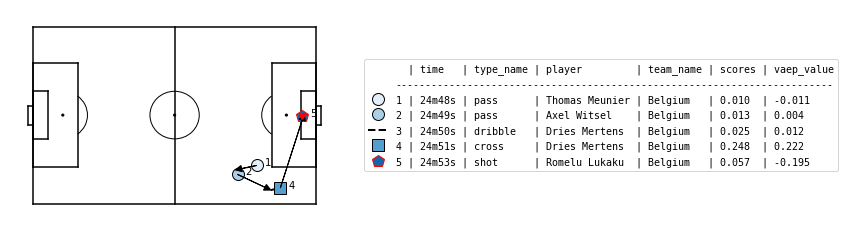

2018-07-02 Belgium 3-2 Japan 73' cross Eden Hazard


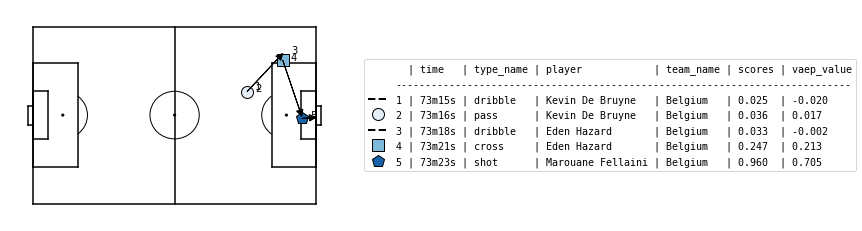

2018-06-23 Belgium 5-2 Tunisia 89' cross Youri Tielemans


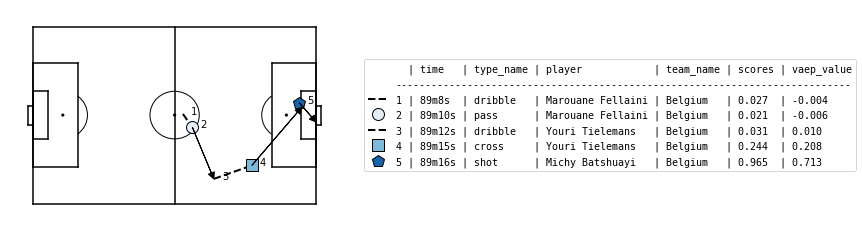

2018-07-10 France 1-0 Belgium 46' pass Axel Witsel


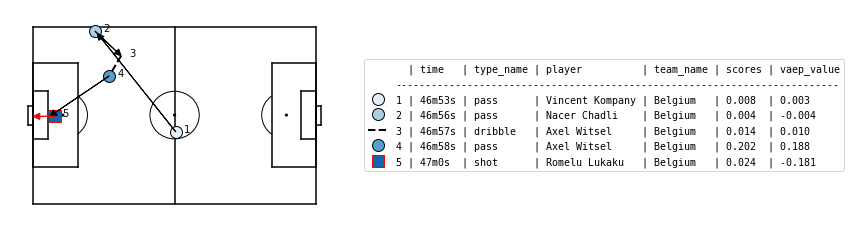

2018-07-10 France 1-0 Belgium 21' corner_crossed Nacer Chadli


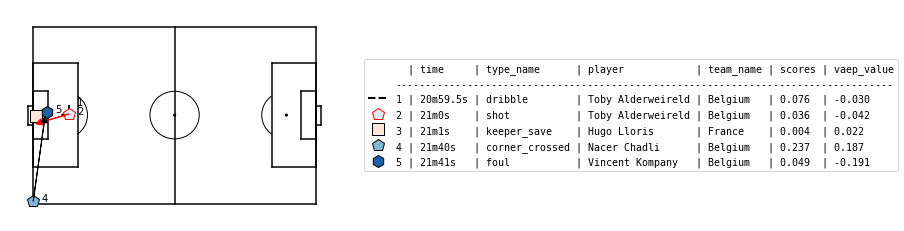

2018-06-23 Belgium 5-2 Tunisia 47' pass Thomas Meunier


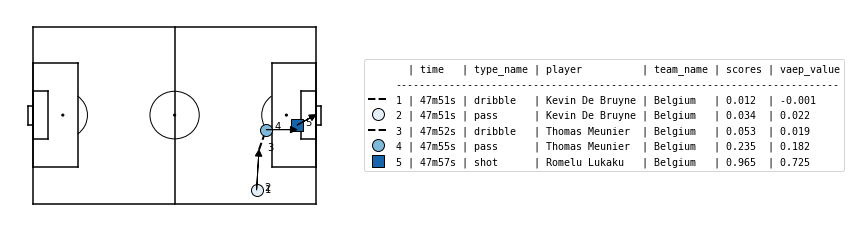

In [10]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)